In [49]:
from wbfm.utils.projects.finished_project_data import ProjectData
from wbfm.utils.general.utils_paper import apply_figure_settings
import plotly.express as px
import pandas as pd

# Step 1: using my project class

Note: you will need to update the path if you are not on the cluster. If you have /scratch mounted, this might work:

fname = "Z:/neurobiology/zimmer/fieseler/wbfm_projects/2022-11-27_spacer_7b_2per_agar/ZIM2165_Gcamp7b_worm1-2022_11_28/project_config.yaml"

In [2]:
fname = "/lisc/scratch/neurobiology/zimmer/fieseler/wbfm_projects/2022-11-27_spacer_7b_2per_agar/ZIM2165_Gcamp7b_worm1-2022_11_28/project_config.yaml"
project_data_gcamp = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/fieseler/wbfm_projects/2022-11-27_spacer_7b_2per_agar/ZIM2165_Gcamp7b_worm1-2022_11_28 
With raw data in directory:
/lisc/scratch/neurobiology/zimmer/ulises/wbfm/20221127/data/ZIM2165_Gcamp7b_worm1/2022-11-27_15-14_ZIM2165_worm1_GC7b_Ch0-BH 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                True
final_tracks:             True
manual_tracking:          True
============Traces=====================
traces:                   True




# Step 2: get the tracks as a pandas dataframe

This is a multi-index dataframe with the name on the top, and the physical metadata as nested columns

Note that these positions are relative to the image

In [151]:
# We choose the red channel, but both have the same location
df = project_data_gcamp.red_traces.copy()

In [158]:
# Subtract the center point
df.loc[:, (slice(None), 'x')] -= 650 / 2
df.loc[:, (slice(None), 'y')] -= 900 / 2

In [159]:
# Convert to physical units (mm)
um_per_pix = project_data_gcamp.physical_unit_conversion.zimmer_fluroscence_um_per_pixel_xy
df.loc[:, (slice(None), ['x', 'y'])] *= um_per_pix / 1000

In [160]:
df.head()

DB01                                                      neuron_002  \
     area          z         x         y intensity_image label       area   
0   853.0  11.335318  0.050922  0.045706        715702.0   1.0      629.0   
1  1150.0  10.860266  0.070142  0.057112        528019.0   1.0      593.0   
2  1121.0  11.174636  0.083742  0.042024        504811.0   1.0      503.0   
3  1094.0  10.786388  0.083906  0.033608        547049.0   1.0      639.0   
4  1018.0  10.665201  0.075539  0.037268        571779.0   1.0      656.0   

                                 ... neuron_147                            \
          z         x         y  ...          x   y intensity_image label   
0  4.046886  0.014628 -0.006489  ...        NaN NaN             NaN   NaN   
1  4.521658  0.009171 -0.004492  ...        NaN NaN             NaN   NaN   
2  3.920861  0.008505 -0.001361  ...        NaN NaN             NaN   NaN   
3  3.994679  0.006863  0.000811  ...        NaN NaN             NaN   NaN   
4  3.868562  0.007118 -0.002459  ...        NaN NaN             NaN   NaN   

  neuron_149                                    
        area   z   x   y intensity_image label  
0        NaN NaN NaN NaN             NaN   NaN  
1        NaN NaN NaN NaN             NaN   NaN  
2        NaN NaN NaN NaN             NaN   NaN  
3        NaN NaN NaN NaN             NaN   NaN  
4        NaN NaN NaN NaN             NaN   NaN  

[5 rows x 948 columns]

## Rename columns with manual IDs, if any

In [161]:
name_mapping = project_data_gcamp.neuron_name_to_manual_id_mapping(confidence_threshold=0)
df.rename(columns=name_mapping, level=0, inplace=True)

# Step 3: correct for the relative positioning using the absolute stage position

In [162]:
df_stage_position = project_data_gcamp.worm_posture_class.stage_position(fluorescence_fps=True, reset_index=True).rename(columns={'X':'x', 'Y':'y'})
df_stage_position.head()

,x,y
0,-0.8285,-2.8997
1,-0.8484,-2.9171
2,-0.8723,-2.9317
3,-0.8950,-2.9526
4,-0.9110,-2.9735


In [163]:
# Offset the relative values
x_abs = df.loc[:, (slice(None), 'x')].add(df_stage_position['x'].values, axis=0)
y_abs = df.loc[:, (slice(None), 'y')].add(df_stage_position['y'].values, axis=0)
# Also include the original stage position for later plotting
df_stage_position = pd.concat({'stage_position': df_stage_position}, axis=1)

df_abs = pd.concat([x_abs, y_abs, df_stage_position], axis=1)
df_abs.head()

DB01 neuron_002 neuron_003 neuron_004 neuron_005      RIVL neuron_007  \
          x          x          x          x          x         x          x   
0 -0.777578  -0.813872  -0.787888  -0.811756  -0.808855 -0.815045  -0.803936   
1 -0.778258  -0.839229  -0.798675  -0.832389  -0.830074 -0.836907  -0.828213   
2 -0.788558  -0.863795  -0.816074  -0.855965  -0.853728 -0.861279  -0.852701   
3 -0.811094  -0.888137  -0.841681  -0.881787  -0.878157 -0.885393  -0.877306   
4 -0.835461  -0.903882  -0.863883  -0.900809  -0.896553 -0.902934  -0.893035   

        RIS neuron_009 neuron_010  ... neuron_155 neuron_057 neuron_105  \
          x          x          x  ...          y          y          y   
0 -0.786454  -0.788626  -0.807815  ...        NaN        NaN        NaN   
1 -0.802493  -0.799659  -0.823328  ...        NaN        NaN        NaN   
2 -0.825314  -0.818535  -0.847591  ...        NaN        NaN        NaN   
3 -0.851991  -0.844928  -0.873754  ...        NaN        NaN        NaN   
4 -0.871661  -0.867118  -0.895615  ...        NaN        NaN        NaN   

  neuron_039 neuron_124 neuron_128 neuron_147 neuron_149 stage_position  \
           y          y          y          y          y              x   
0        NaN        NaN        NaN        NaN        NaN        -0.8285   
1        NaN        NaN        NaN        NaN        NaN        -0.8484   
2        NaN        NaN        NaN        NaN        NaN        -0.8723   
3        NaN        NaN        NaN        NaN        NaN        -0.8950   
4        NaN        NaN        NaN        NaN        NaN        -0.9110   

           
        y  
0 -2.8997  
1 -2.9171  
2 -2.9317  
3 -2.9526  
4 -2.9735  

[5 rows x 318 columns]

# Step 4: plot

In [164]:
df_abs['AVAL'].head()

,x,y
0,-0.816961,-2.910519
1,-0.843839,-2.923062
2,-0.867427,-2.935959
3,-0.890114,-2.955951
4,-0.903954,-2.980534


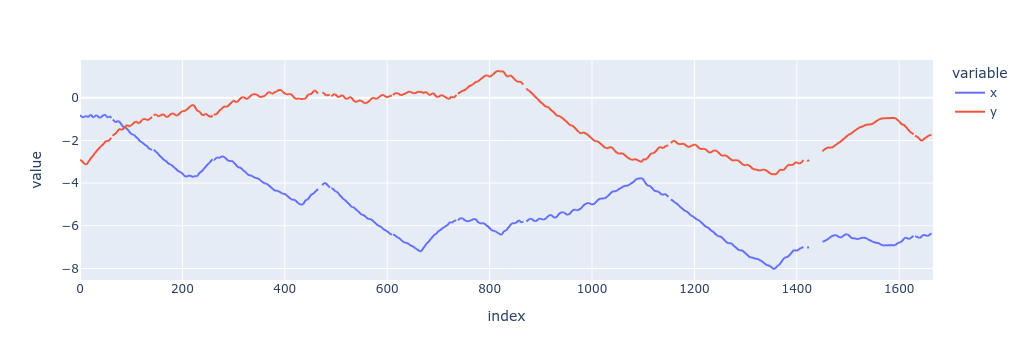

In [165]:
px.line(df_abs['AVAL'])

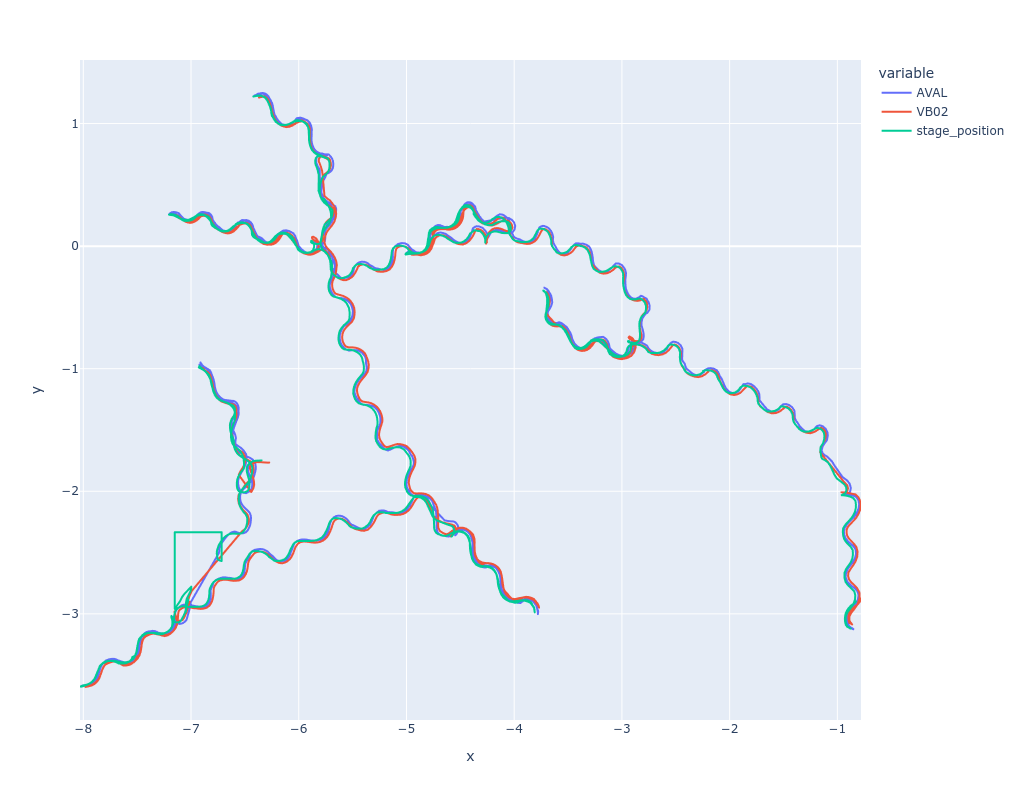

In [168]:
# Compare stage position
_df = df_abs[['AVAL', 'VB02', 'stage_position']].swaplevel(0, 1, axis=1).stack().reset_index(level=1).rename(columns={'level_1': 'variable'})
_df.head()

px.line(_df, x='x', y='y', color='variable', height=800, width=800)